In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
# Translated from MATLAB code, non-linearly separable

# Initialize seed for reproducibility
np.random.seed(1337)

ndata = 100
mA = [1.0, 0.3]
sigmaA = 0.2
mB = [0.0, -0.1]
sigmaB = 0.3

# Generate data for class A
classA = pd.DataFrame({
    'x1': np.concatenate([
        np.random.randn(round(0.5 * ndata)) * sigmaA - mA[0],
        np.random.randn(round(0.5 * ndata)) * sigmaA + mA[0],
    ]),
    'x2': np.random.randn(ndata) * sigmaA + mA[1],
    'y': np.full(shape=ndata, fill_value=1),
})

# Generate data for class B
classB = pd.DataFrame({
    'x1': np.random.randn(ndata) * sigmaB + mB[0],
    'x2': np.random.randn(ndata) * sigmaB + mB[1],
    'y': np.full(shape=ndata, fill_value=-1),
})


dataset = pd.concat([classA, classB])
dataset = dataset.sample(frac=1).reset_index(drop=True) # shuffle all rows

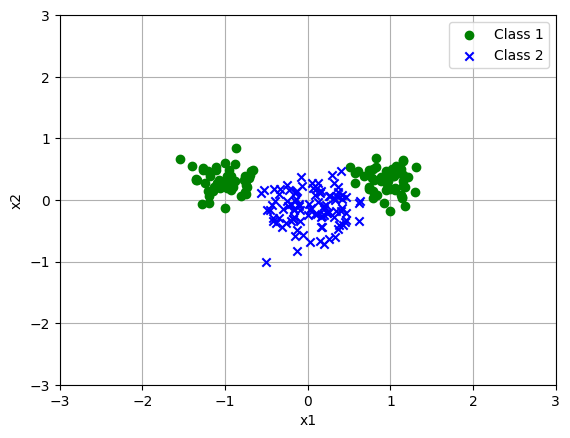

In [3]:
# Plot the generated dataset 
plt.scatter(classA["x1"], classA["x2"], c="green", label="Class 1", zorder=2, marker="o")
plt.scatter(classB["x1"], classB["x2"], c="blue", label="Class 2", zorder=2, marker="x")
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.legend()
plt.savefig('images/dataset.png')
plt.show()

In [4]:
# Create subsamples where the removed data becomes a validation set

# 25% removed
dataset_25 = dataset.copy()
dataset_25 = dataset_25.sample(frac=0.75).reset_index(drop=True)
dataset_25_val = dataset.copy()
dataset_25_val = dataset_25_val.drop(dataset_25.index).reset_index(drop=True)

# 50% removed of class 1
classA_50 = classA.sample(frac=0.5).reset_index(drop=True)
dataset_50A = pd.concat([classA_50, classB])
dataset_50A = dataset_50A.sample(frac=1).reset_index(drop=True)
dataset_50A_val = dataset.copy()
dataset_50A_val = dataset_50A_val.drop(dataset_50A.index).reset_index(drop=True)

# 50% removed of class 2
classB_50 = classB.sample(frac=0.5).reset_index(drop=True)
dataset_50B = pd.concat([classA, classB_50])
dataset_50B = dataset_50B.sample(frac=1).reset_index(drop=True)
dataset_50B_val = dataset.copy()
dataset_50B_val = dataset_50B_val.drop(dataset_50B.index).reset_index(drop=True)

# Remove 20% from a subset of class a for which classA(1,:)<0 and 80% from a subset of classA for which classA(1,:)>0
classA_80 = dataset[dataset["x1"] < 0].sample(frac=0.8).reset_index(drop=True)
classA_20 = dataset[dataset["x1"] > 0].sample(frac=0.2).reset_index(drop=True)
dataset_80_20 = pd.concat([classA_80, classA_20, classB])
dataset_80_20 = dataset_80_20.sample(frac=1).reset_index(drop=True)
dataset_80_20_val = dataset.copy()
dataset_80_20_val = dataset_80_20_val.drop(dataset_80_20.index).reset_index(drop=True)

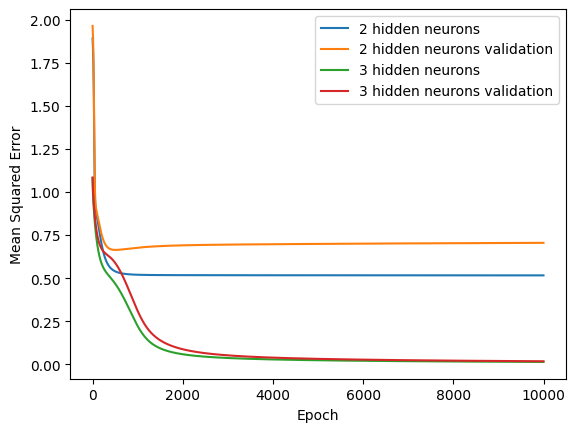

In [5]:
import importlib
import sys
#from PerceptronSingle import Perceptron
from MLP import MLP

# Reload the module using sys.modules to avoid having to restart notebook kernel when module is updated
importlib.reload(sys.modules['MLP'])

# Hyperparameters
eta = 0.001

# Train three networks with 1, 2 and 3 hidden neurons

h1 = 1
h2 = 2
h3 = 3

Ws1 = []
Ws1.append(np.random.normal(size=(3, h1), loc=0, scale=1))
Ws1.append(np.random.normal(size=(h1+1, 1), loc=0, scale=1))

Ws2 = []
Ws2.append(np.random.normal(size=(3, h2), loc=0, scale=1))
Ws2.append(np.random.normal(size=(h2+1, 1), loc=0, scale=1))

Ws3 = []
Ws3.append(np.random.normal(size=(3, h3), loc=0, scale=1))
Ws3.append(np.random.normal(size=(h3+1, 1), loc=0, scale=1))


for i, data in enumerate([(dataset_25, dataset_25_val), (dataset_50A, dataset_50A_val), (dataset_50B, dataset_50B_val), (dataset_80_20, dataset_80_20_val)]):
    nn1 = MLP(copy.deepcopy(Ws1), eta)
    Ws_history1, acc_history1, MSE_history1, val_MSE_history1 = nn1.train_model(data[0], data[1], 10000)
    
    nn2 = MLP(copy.deepcopy(Ws2), eta)
    Ws_history2, acc_history2, MSE_history2, val_MSE_history2 = nn2.train_model(data[0], data[1], 10000)
    
    nn3 = MLP(copy.deepcopy(Ws3), eta)
    Ws_history3, acc_history3, MSE_history3, val_MSE_history3 = nn3.train_model(data[0], data[1], 10000)

    if i == 1:
        break
    
    # Plot accuracy / MSE
    # plt.plot(MSE_history1, label="1 hidden neuron")
    # plt.plot(val_MSE_history1, label="1 hidden neuron validation")
    plt.plot(MSE_history2, label="2 hidden neurons")
    plt.plot(val_MSE_history2, label="2 hidden neurons validation")
    plt.plot(MSE_history3, label="3 hidden neurons")
    plt.plot(val_MSE_history3, label="3 hidden neurons validation")
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.savefig(f'images/MSE_{i}.png')
    plt.show()

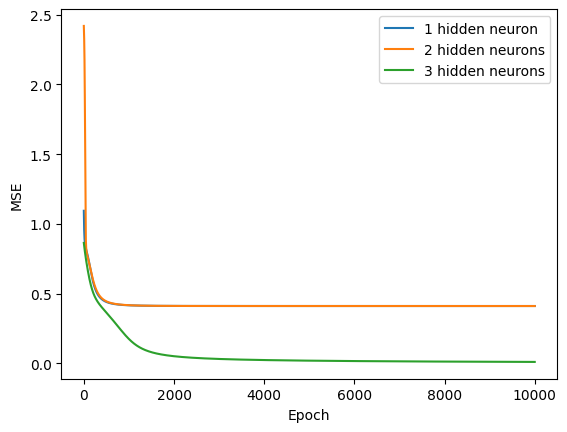

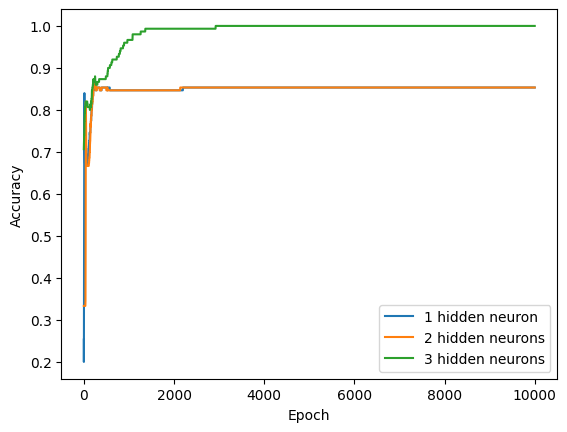

In [6]:
# Plot MSE and accuracy for first 1000 epochs of the three networks
plt.plot(MSE_history1[:10000])
plt.plot(MSE_history2[:10000])
plt.plot(MSE_history3[:10000])
plt.legend(['1 hidden neuron', '2 hidden neurons', '3 hidden neurons'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.savefig('images/MSE_hidden_layer_sizes.png')
plt.show()

plt.plot(acc_history1[:10000])
plt.plot(acc_history2[:10000])
plt.plot(acc_history3[:10000])
plt.legend(['1 hidden neuron', '2 hidden neurons', '3 hidden neurons'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('images/accuracy_hidden_layer_sizes.png')
plt.show()


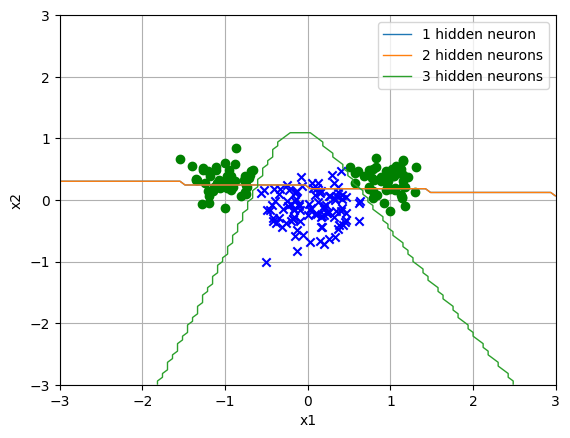

In [7]:
# Draw the three decision boundaries from weights

# Plot the generated dataset 
plt.scatter(classA["x1"], classA["x2"], c="green", label="Class 1", zorder=2, marker="o")
plt.scatter(classB["x1"], classB["x2"], c="blue", label="Class 2", zorder=2, marker="x")
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()

# Draw decision boundaries
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.array([X1.ravel(), X2.ravel()]).T

# Use matplotlib default colors for first, second and third decision boundary
Z1 = nn1.predict(X)
Z1 = Z1.reshape(X1.shape)
plt.contour(X1, X2, Z1, levels=[0], colors="#1f77b4", linewidths=1)

Z2 = nn2.predict(X)
Z2 = Z2.reshape(X1.shape)
plt.contour(X1, X2, Z2, levels=[0], colors="#ff7f0e", linewidths=1)

Z3 = nn3.predict(X)
Z3 = Z3.reshape(X1.shape)
plt.contour(X1, X2, Z3, levels=[0], colors="#2ca02c", linewidths=1)

# Add custom entries to legend with same color as decision boundaries
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#1f77b4', lw=1),
                Line2D([0], [0], color='#ff7f0e', lw=1),
                Line2D([0], [0], color='#2ca02c', lw=1)]
plt.legend(custom_lines, ['1 hidden neuron', '2 hidden neurons', '3 hidden neurons'])

plt.savefig('images/decision_boundary_hidden_layer_sizes.png')
plt.show()

**3.2.3 Function approximation**

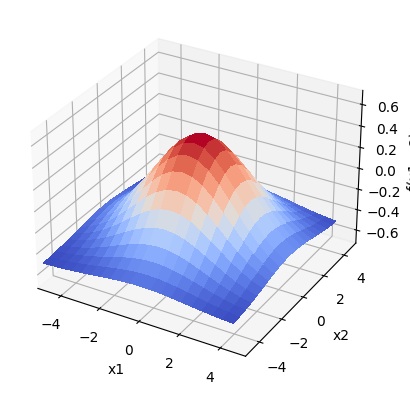

In [8]:
# Translated from MATLAB code
x1 = np.arange(-5, 5, 0.5)
x2 = np.arange(-5, 5, 0.5)

def f(x1, x2):
    return np.exp(-(x1**2 + x2**2)/10) - 0.5

#plot the function in 3d    

fig = plt.figure()
ax = plt.axes(projection='3d')
X1, X2 = np.meshgrid(x1, x2, indexing='xy')
Z = f(X1, X2)
surf = ax.plot_surface(X1, X2, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1, x2)')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-0.7, 0.7)
#plt.savefig('images/3d_function.png')
plt.show()


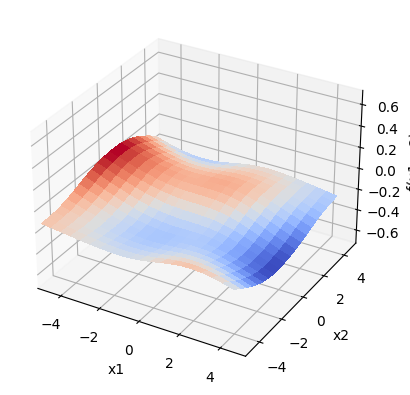

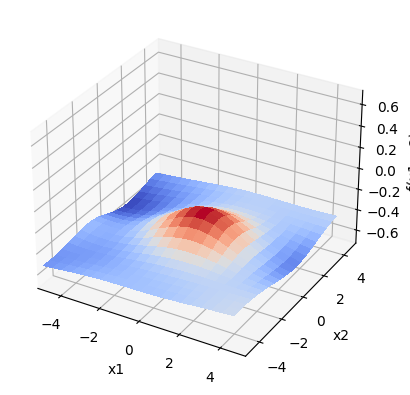

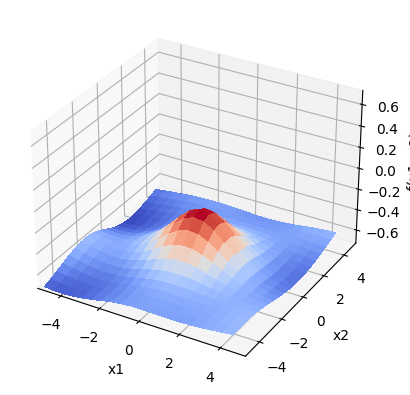

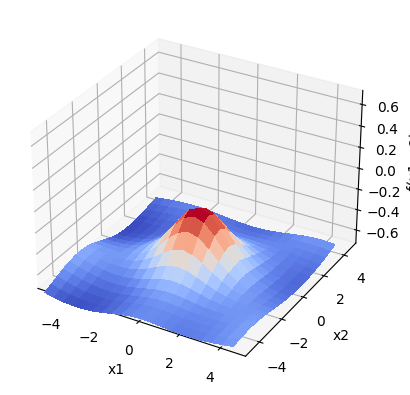

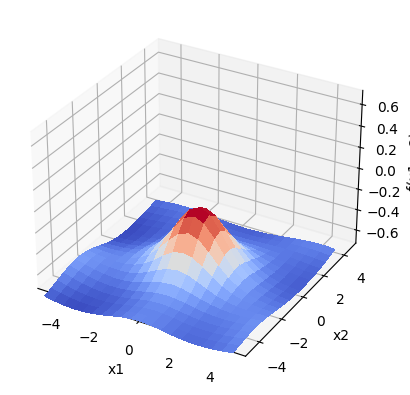

In [18]:

ndata = len(x1) * len(x2)
targets = Z.reshape(ndata)

X1 = X1.reshape(ndata) 
X2 = X2.reshape(ndata)

eta = 0.005
h2 = 8

Ws2 = []
Ws2.append(np.random.normal(size=(3, h2), loc=0, scale=0.5))
Ws2.append(np.random.normal(size=(h2+1, 1), loc=0, scale=0.5))

#create a dataframe with patterns and targets

dataset_Gaussian = pd.DataFrame({
    'x1': X1,
    'x2': X2,
    'y':  targets
    })

nn2 = MLP(copy.deepcopy(Ws2), eta)
Ws_history2, acc_history2, MSE_history2, val_MSE_history2 = nn2.train_model(dataset_Gaussian, dataset_Gaussian, 1000)


y_hat = []
num_epochs = []
# int(len(Ws_history2)/5)
for i in range(0, len(Ws_history2), 50):
    y_hat.append(nn2._forward(dataset_Gaussian, Ws_history2[i])[-1].squeeze())
    num_epochs.append(i)
    if i == 200:
        break
#create np array from list
y_hat = np.array(y_hat)

zz = np.zeros((5, 20, 20))

X1, X2 = np.meshgrid(x1, x2, indexing='xy')
for i in range(len(y_hat)):
    zz[i] = y_hat[i].reshape(len(x1), len(x2))

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X1, X2, zz[i], cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1, x2)')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-0.7, 0.7)
    #plt.legend(['Epoch ' + str(num_epochs[i])])
    plt.savefig(f'images/gauss_{num_epochs[i]}_h{h2}.png')
    plt.show()


In [19]:
# Create subsamples where the removed data + the training data becomes a validation set

# 25% removed
dataset_Gaussian_25 = dataset_Gaussian.copy()
dataset_Gaussian_25 = dataset_Gaussian_25.sample(random_state=1337, frac=0.75).reset_index(drop=True)
dataset_Gaussian_25_val = dataset_Gaussian.copy()

# 50% removed
dataset_Gaussian_50 = dataset_Gaussian.copy()
dataset_Gaussian_50 = dataset_Gaussian_50.sample(random_state=1337, frac=0.5).reset_index(drop=True)
dataset_Gaussian_50_val = dataset_Gaussian.copy()

# 75% removed
dataset_Gaussian_75 = dataset_Gaussian.copy()
dataset_Gaussian_75 = dataset_Gaussian_75.sample(random_state=1337, frac=0.25).reset_index(drop=True)
dataset_Gaussian_75_val = dataset_Gaussian.copy()

# 90% removed
dataset_Gaussian_90 = dataset_Gaussian.copy()
dataset_Gaussian_90 = dataset_Gaussian_90.sample(random_state=1337, frac=0.1).reset_index(drop=True)
dataset_Gaussian_90_val = dataset_Gaussian.copy()






In [20]:
import importlib
import sys
#from PerceptronSingle import Perceptron
from MLP import MLP

# Reload the module using sys.modules to avoid having to restart notebook kernel when module is updated
importlib.reload(sys.modules['MLP'])

# Hyperparameters
eta = 0.005
epochs = 100

h1 = 1
h2 = 2
h3 = 10
h4 = 15
h5 = 25

Ws1 = []
Ws1.append(np.random.normal(size=(3, h1), loc=0, scale=1))
Ws1.append(np.random.normal(size=(h1+1, 1), loc=0, scale=1))

Ws2 = []
Ws2.append(np.random.normal(size=(3, h2), loc=0, scale=1))
Ws2.append(np.random.normal(size=(h2+1, 1), loc=0, scale=1))

Ws3 = []
Ws3.append(np.random.normal(size=(3, h3), loc=0, scale=1))
Ws3.append(np.random.normal(size=(h3+1, 1), loc=0, scale=1))

Ws4 = []
Ws4.append(np.random.normal(size=(3, h4), loc=0, scale=1))
Ws4.append(np.random.normal(size=(h4+1, 1), loc=0, scale=1))

Ws5 = []
Ws5.append(np.random.normal(size=(3, h5), loc=0, scale=1))
Ws5.append(np.random.normal(size=(h5+1, 1), loc=0, scale=1))


for i, data in enumerate([(dataset_Gaussian_25, dataset_Gaussian_25_val), (dataset_Gaussian_50, dataset_Gaussian_50), (dataset_Gaussian_75, dataset_Gaussian_75_val), (dataset_Gaussian_90, dataset_Gaussian_90_val)]):
    nn1 = MLP(copy.deepcopy(Ws1), eta)
    Ws_history1, acc_history1, MSE_history1, val_MSE_history1 = nn1.train_model(data[0], data[1], epochs)
    
    nn2 = MLP(copy.deepcopy(Ws2), eta)
    Ws_history2, acc_history2, MSE_history2, val_MSE_history2 = nn2.train_model(data[0], data[1], epochs)
    
    nn3 = MLP(copy.deepcopy(Ws3), eta)
    Ws_history3, acc_history3, MSE_history3, val_MSE_history3 = nn3.train_model(data[0], data[1], epochs)
    
    nn4 = MLP(copy.deepcopy(Ws4), eta)
    Ws_history4, acc_history4, MSE_history4, val_MSE_history4 = nn4.train_model(data[0], data[1], epochs)

    nn5 = MLP(copy.deepcopy(Ws5), eta)
    Ws_history5, acc_history5, MSE_history5, val_MSE_history5 = nn5.train_model(data[0], data[1], epochs)


    #plt.plot(MSE_history1, label="1 hidden neurons")
    #plt.plot(val_MSE_history1, label="1 hidden neurons validation")
    #plt.plot(MSE_history2, label="2 hidden neurons")
    #plt.plot(val_MSE_history2, label="2 hidden neurons validation")
    #plt.plot(MSE_history3, label="10 hidden neurons")  
    #plt.plot(val_MSE_history3, label="10 hidden neurons validation")
    #plt.plot(MSE_history4, label="15 hidden neurons")
    #plt.plot(val_MSE_history4, label="15 hidden neurons validation")
    #plt.plot(MSE_history5, label="25 hidden neurons")
    #plt.plot(val_MSE_history5, label="25 hidden neurons validation")
    #plt.xlabel('Epoch')
    #plt.ylabel('Mean Squared Error')
    #plt.legend()
    ##plt.xlim(80, 100)
    #plt.savefig(f'images/MSE_{i}.png')
    #plt.show()




In [21]:




num_it = 100

MSE_final = np.zeros((num_it,5))
val_MSE_final = np.zeros((num_it,5))

for j in range(num_it):   
    h1 = 1
    h2 = 2
    h3 = 10
    h4 = 15
    h5 = 25

    Ws1 = []
    Ws1.append(np.random.normal(size=(3, h1), loc=0, scale=1))
    Ws1.append(np.random.normal(size=(h1+1, 1), loc=0, scale=1))

    Ws2 = []
    Ws2.append(np.random.normal(size=(3, h2), loc=0, scale=1))
    Ws2.append(np.random.normal(size=(h2+1, 1), loc=0, scale=1))

    Ws3 = []
    Ws3.append(np.random.normal(size=(3, h3), loc=0, scale=1))
    Ws3.append(np.random.normal(size=(h3+1, 1), loc=0, scale=1))

    Ws4 = []
    Ws4.append(np.random.normal(size=(3, h4), loc=0, scale=1))
    Ws4.append(np.random.normal(size=(h4+1, 1), loc=0, scale=1))

    Ws5 = []
    Ws5.append(np.random.normal(size=(3, h5), loc=0, scale=1))
    Ws5.append(np.random.normal(size=(h5+1, 1), loc=0, scale=1))
    
    Ws_i = [Ws1, Ws2, Ws3, Ws4, Ws5] 

    for i in range(len(Ws_i)):
        nn = MLP(copy.deepcopy(Ws_i[i]), eta)
        Ws_history, acc_history, MSE_history, val_MSE_history = nn.train_model(dataset_Gaussian, dataset_Gaussian, epochs)
        MSE_final[j][i] = MSE_history[-1]
        val_MSE_final[j][i] = val_MSE_history[-1]

        #MSE_final.append(MSE_history[-1])
        #val_MSE_final.append(val_MSE_history[-1])

        #y_hat = nn._forward(dataset_Gaussian, Ws_history[-1])[-1]
    #fig = plt.figure()
    #ax = plt.axes(projection='3d')
    #
    #surf = ax.plot_surface(X1, X2, y_hat.reshape(20,20), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    #ax.set_xlabel('x1')
    #ax.set_ylabel('x2')
    #ax.set_zlabel('f(x1, x2)')
    #ax.set_xlim(-5, 5)
    #ax.set_ylim(-5, 5)
    #ax.set_zlim(-0.7, 0.7)
    ##plt.legend(['Epoch ' + str(num_epochs[i])])
    ##plt.savefig(f'images/3d_function_{i}.png')
    #plt.show()

#print(MSE_final)
#print(val_MSE_final)

# find mean mse for each hidden layer size
mean_MSE = np.mean(MSE_final, axis=0)

labels = ['1', '2', '10', '15', '25']

#zi = zip(labels, mean_MSE)

#pair labels with mean mse


    

In [22]:
print(mean_MSE)

[0.06619467 0.054755   0.01366596 0.02891118 0.11380186]


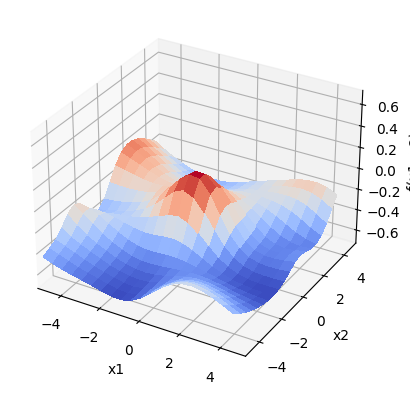

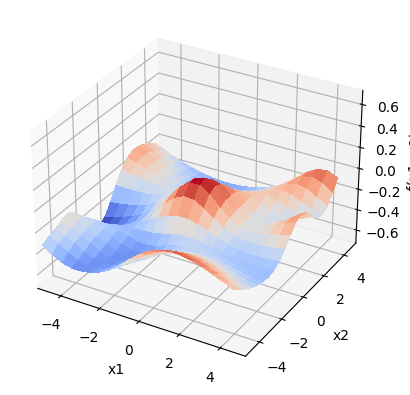

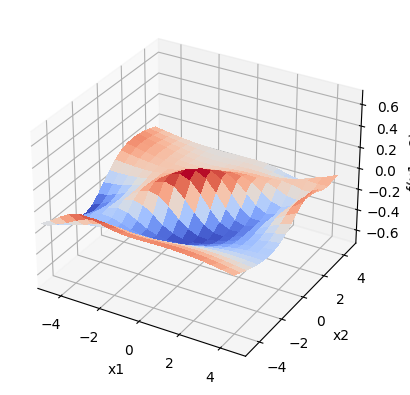

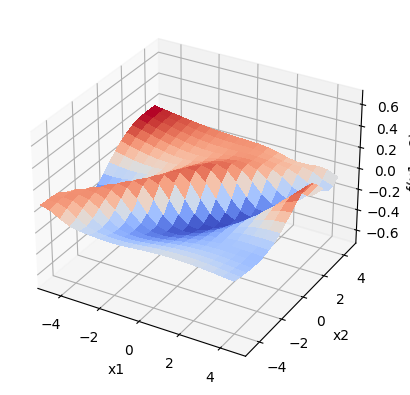

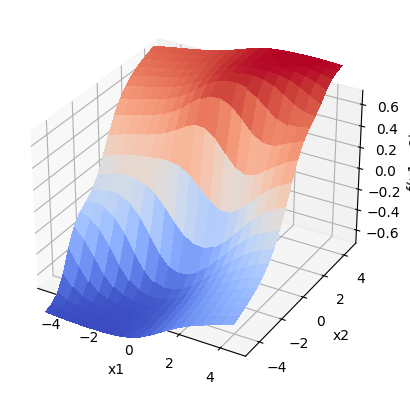

In [27]:
#Experiments for selected best model




for i, data in enumerate([(dataset_Gaussian_25, dataset_Gaussian_25_val), (dataset_Gaussian_50, dataset_Gaussian_50), (dataset_Gaussian_75, dataset_Gaussian_75_val), (dataset_Gaussian_90, dataset_Gaussian_90_val)]):
    nn = MLP(copy.deepcopy(Ws3), eta)
    Ws_history, acc_history, MSE_history, val_MSE_history = nn.train_model(data[0], data[1], epochs)
  
    y_hat = nn._forward(dataset_Gaussian, Ws_history[-1])[-1]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    surf = ax.plot_surface(X1, X2, y_hat.reshape(20,20), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1, x2)')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_zlim(-0.7, 0.7)
    #plt.legend(['Epoch ' + str(num_epochs[i])])
    plt.savefig(f'images/gauss_subsample{i}.png')
    plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
y_hat = nn._forward(dataset_Gaussian, Ws_history[0])[-1]
surf = ax.plot_surface(X1, X2, y_hat.reshape(20,20), cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1, x2)')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-0.7, 0.7)

plt.show()


**Q: For the ”best” model, can you speed up the convergence without compromising the generalisation performance?**
The performance is very sensitive to random initialization. In this case perhaps it is better to initialize the weights so that they form a hyperplan that is orthogonal to the z axis, meaning hte span of hte x and y axes. 